In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/TNKILC"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_TNKILC_clustering.h5ad"
    )
)

### Annotations

In [5]:
adata

AnnData object with n_obs × n_vars = 82184 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI_r1'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Annotation_scVI_colors', 'Cell_subtype_colors', 'Patient_colors', 'Therapy_colors', 'Tissue_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'leiden_scVI_r1_colors', 'log1p', 'neighbors', 'pca', 'phase_colors', 'rank_genes_wilcoxon', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'log1p', 'normalised', 'raw', 'scvi_no

In [6]:
adata[adata.obs.leiden_scVI == "17"].obs.Cell_subtype.value_counts()

CCL5+ CD4+ T cells            251
MAIT cells                    119
ILC                            86
HSP                            80
FOXP3+ Treg                    69
XCL1+ CD8+ T cells             47
CCR6+ Th17                     46
GZMK+ CD8+ T cells             41
CD4+ Naive T cells             29
Naive CD8+ T cells             22
HSP+ CD8+ T cells              21
GPR183+ CD4+ T cells           19
EM CD8 T with B                18
LTB+ CD4+ T cells              14
PDCD1+ CD4+ T cells            13
CTLA4+ CD8+ T cells            11
FGFBP2+ GZMB+ CD8+ T cells     11
GZMB+ NK cells                  8
Naive CD4 T                     7
Treg                            7
Th17                            4
CD52+ CD8+ T cells              4
HSP+ CD4+ T cells               4
IFIT T                          2
GIMAP7+ CD8+ T cells            2
NK2                             1
NK1                             1
No annotation                   1
HSP+ Monocytes                  1
Exhausted CD8 

In [7]:
adata[
    (adata.obs.leiden_scVI == "17") & (adata.obs.cell_source == "Wu-Cells")
].obs.Cell_subtype.value_counts()

CCL5+ CD4+ T cells            251
MAIT cells                    119
FOXP3+ Treg                    69
XCL1+ CD8+ T cells             47
CCR6+ Th17                     46
GZMK+ CD8+ T cells             41
CD4+ Naive T cells             29
Naive CD8+ T cells             22
HSP+ CD8+ T cells              21
GPR183+ CD4+ T cells           19
LTB+ CD4+ T cells              14
PDCD1+ CD4+ T cells            13
CTLA4+ CD8+ T cells            11
FGFBP2+ GZMB+ CD8+ T cells     11
GZMB+ NK cells                  8
CD52+ CD8+ T cells              4
HSP+ CD4+ T cells               4
GIMAP7+ CD8+ T cells            2
HSP+ Monocytes                  1
Name: Cell_subtype, dtype: int64

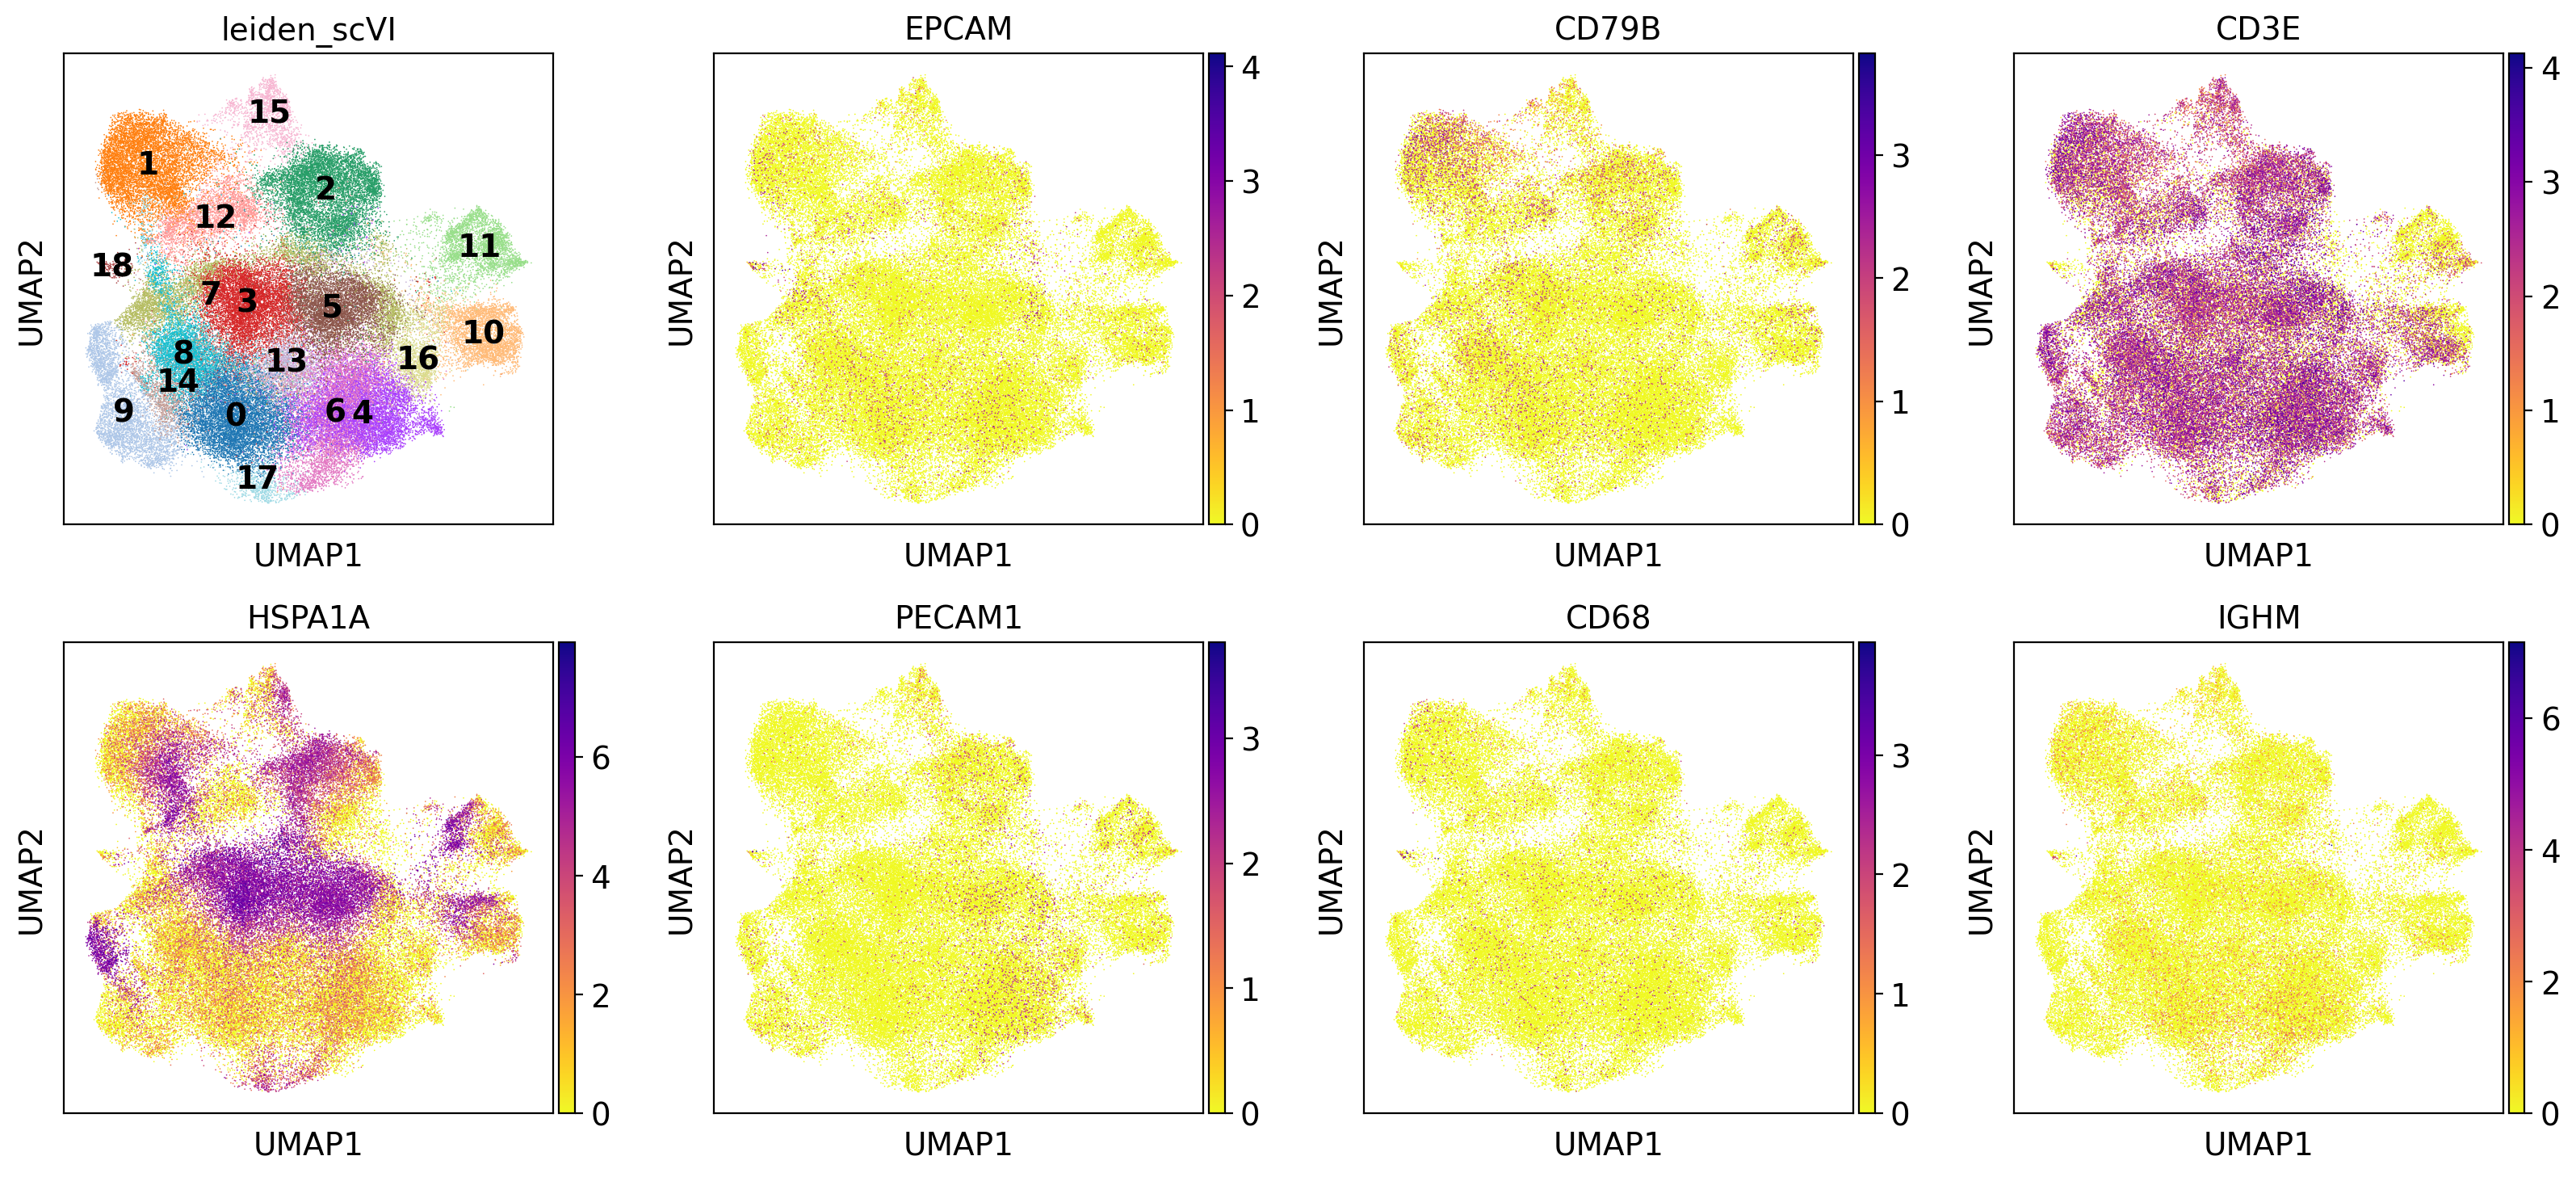

In [8]:
sc.pl.umap(
    adata,
    color=["leiden_scVI", "EPCAM", "CD79B", "CD3E", "HSPA1A", "PECAM1", "CD68", "IGHM"],
    use_raw=True,
    legend_loc="on data",
    cmap="plasma_r",
)

In [9]:
old_to_new = {
    "0": "CD4 Th",  # because IL7R, CD40LG, ANXA1,
    "1": "Treg",  # FOXP3, CTLA4, CCR4, IL2RA
    "2": "CD8 Tex",  # HAVCR2, LAG3, CTLA4,..
    "3": "CD4 Th HSP",  # HSP + CD40LG, IL7R, ANXA1
    "4": "CD8 Tem",  # CD8A, CD8B, GZMK
    "5": "CD8 Tem HSP",  # HSP, GZMK
    "6": "CD8 Tem with B cell contamination",  # but has Che B cell contamination (IGLC3, IGHM) and FOS and JUNB (maybe we should remove it actually), MT1X genes,
    "7": "CD4-CD8",
    "8": "CD4 Tn",  # CCR7, SELL, LEF1
    "9": "MAIT",  # SLC4A10, NCR3, KLRB1
    "10": "NKT",  # FGFBP2
    "11": "NK",  # NCAM1, FCER1G, KLRC1
    "12": "CD4 Tfh",  # PDCD1, ITM2A
    "13": "CD8 Tem GZMB",  # GZMB
    "14": "CD4 Th17",  # ODF2L, IL7R, PDE4D, CD4
    "15": "T cycling",
    "16": "gdT",  # TRDC, TRGC1,
    "17": "HSP",
    "18": "B-T doublet",
}

In [10]:
adata.obs["Annotation_scVI_detailed"] = (
    adata.obs["leiden_scVI"].map(old_to_new).astype("category")
)

### Colours

In [11]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['CD4 Th',
 'Treg',
 'CD8 Tex',
 'CD4 Th HSP',
 'CD8 Tem',
 'CD8 Tem HSP',
 'CD8 Tem with B cell contamination',
 'CD4-CD8',
 'CD4 Tn',
 'MAIT',
 'NKT',
 'NK',
 'CD4 Tfh',
 'CD8 Tem GZMB',
 'CD4 Th17',
 'T cycling',
 'gdT',
 'HSP',
 'B-T doublet']

In [12]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#fa9fb5",
    "#33a02c",
    "#ff7f00",
    "#beaed4",
    "#e31a1c",
    "#800026",
    "#810f7c",
    "#b2df8a",
    "#b15928",
    "#7fc97f",
    "#a6cee3",
    "#dd3497",
    "#1f78b4",
    "#fc9272",
    "#fdbf6f",
    "#ffff99",
    "#6a3d9a",
    "#969696",
    "#9ebcda",
]

### Before removal of bad clusters 

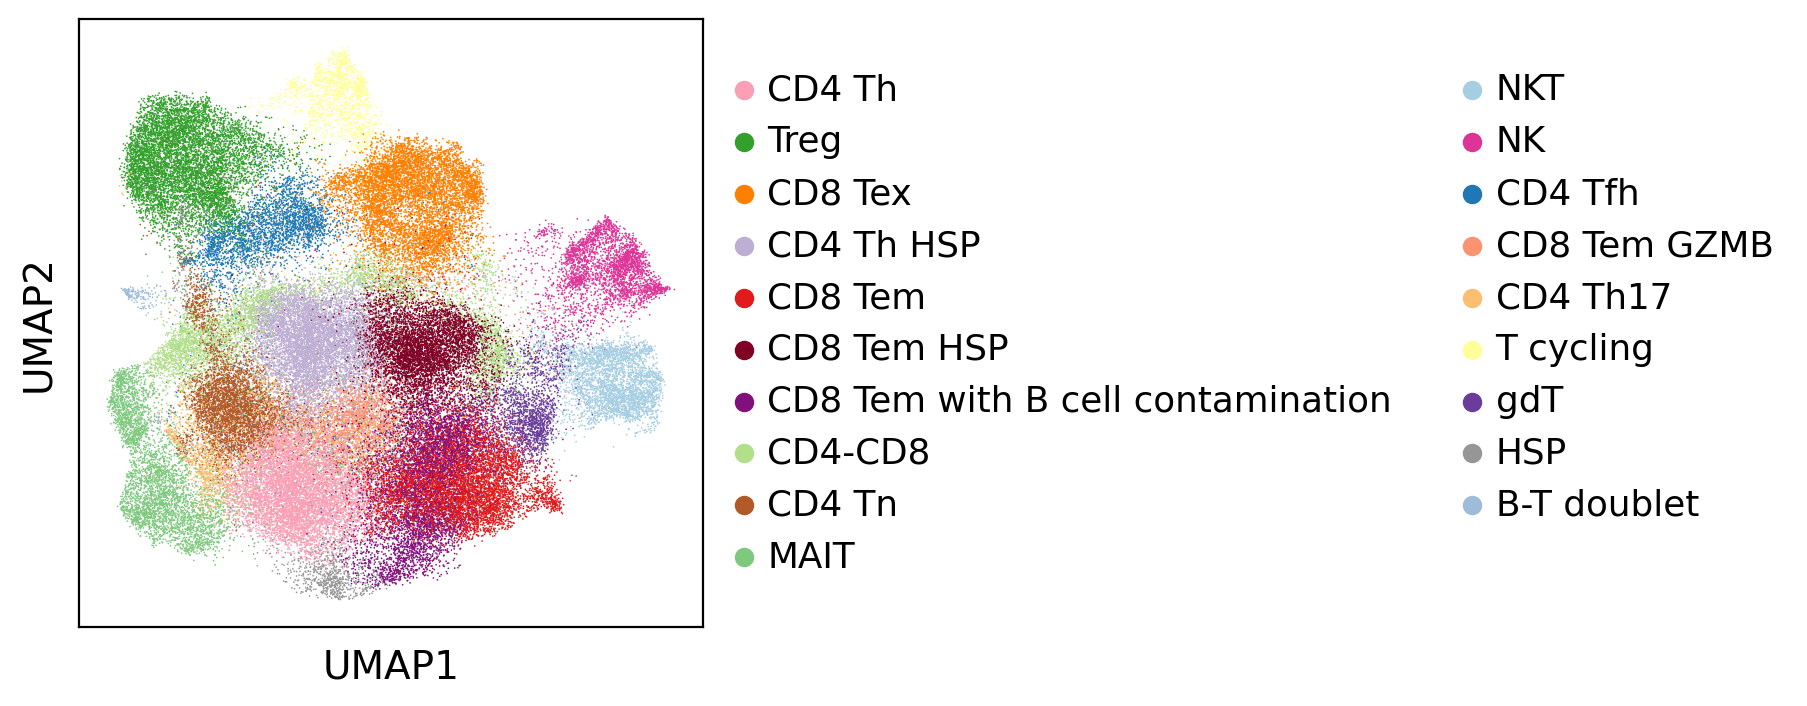

In [13]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations_before_removal_bad_clusters.pdf",
    title="",
)

### Remove clusters with problems:

In [14]:
adata = adata[
    ~adata.obs["Annotation_scVI_detailed"].isin(
        ["B-T doublet", "HSP", "CD8 Tem with B cell contamination"]
    )
].copy()

In [15]:
adata.obs["Annotation_scVI_detailed"].value_counts()

CD4 Th          7802
Treg            7655
CD8 Tex         7531
CD4 Th HSP      7246
CD8 Tem         7079
CD8 Tem HSP     6178
CD4-CD8         5159
CD4 Tn          4778
MAIT            4463
NKT             3695
NK              3191
CD4 Tfh         3010
CD8 Tem GZMB    2239
CD4 Th17        1937
T cycling       1774
gdT             1761
Name: Annotation_scVI_detailed, dtype: int64

### Change colours 

In [16]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['CD4 Th',
 'Treg',
 'CD8 Tex',
 'CD4 Th HSP',
 'CD8 Tem',
 'CD8 Tem HSP',
 'CD4-CD8',
 'CD4 Tn',
 'MAIT',
 'NKT',
 'NK',
 'CD4 Tfh',
 'CD8 Tem GZMB',
 'CD4 Th17',
 'T cycling',
 'gdT']

In [17]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#fa9fb5",
    "#33a02c",
    "#ff7f00",
    "#beaed4",
    "#e31a1c",
    "#800026",
    "#b2df8a",
    "#b15928",
    "#7fc97f",
    "#a6cee3",
    "#dd3497",
    "#1f78b4",
    "#fc9272",
    "#fdbf6f",
    "#ffff99",
    "#6a3d9a",
]

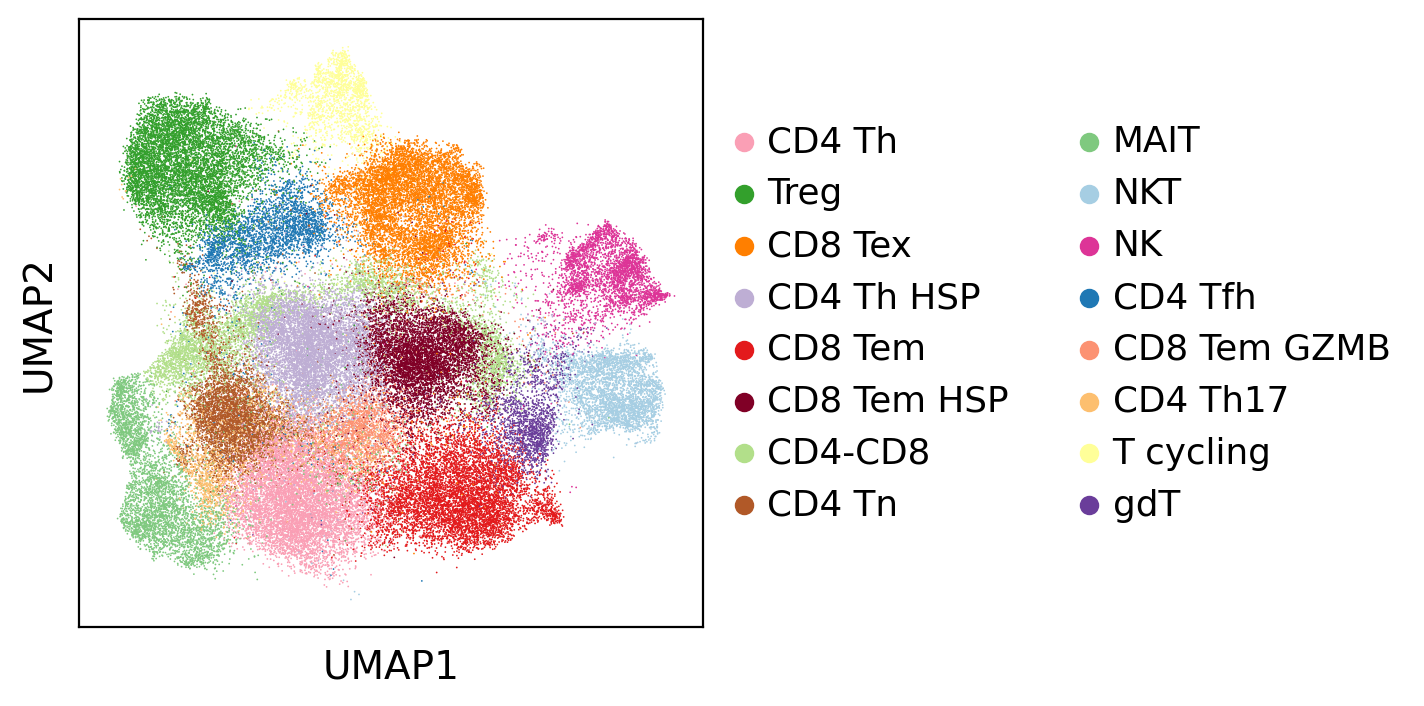

In [18]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations.pdf",
    title="",
)

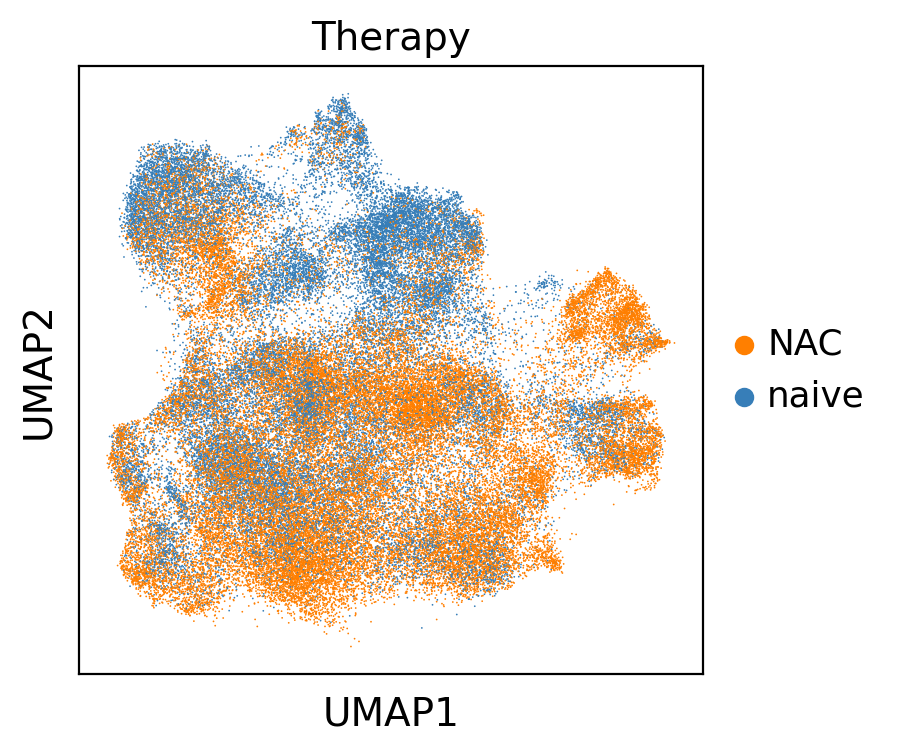

In [19]:
sc.pl.umap(
    adata, color="Therapy", show=True, legend_loc="right margin", save="therapy.pdf"
)

### Write to file

In [20]:
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_TNKILC_clustering_annotations.h5ad"
    )
)

# write csv of annotations
adata.obs["Annotation_scVI_detailed"].to_csv(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_TNKILC_clustering_annotations.txt"
    ),
    sep="\t",
    index=True,
    header=True,
)

### markers polished up

In [21]:
# todo dotplot with all cell types annotated
markers = {
    "T": ["TRAC"],
    "CD4": ["CD4"],
    "CD8": ["CD8A", "CD8B"],
    "Cycling": ["MKI67"],
    "Treg": ["FOXP3", "CTLA4", "IL2RA"],
    "Exhausted T": [
        "PDCD1",
        "LAG3",
        "HAVCR2",
        "CTLA4",
        "TIGIT",
        "ENTPD1",
    ],  # PD1: PCDC1, TIM3: HAVCR2,  CD39:ENTPD1 https://www.nature.com/articles/s41467-021-23324-4
    "NK": ["NCAM1", "FCER1G", "KLRC1"],
    "ILC": ["AREG", "TLE1", "IL4I1"],
    "Th": ["IL7R", "CD40LG", "ANXA1"],
    "Tfh": ["ITM2A", "LPAR6", "PDCD1"],
    "Naïve CD4 T": ["CCR7", "SELL", "TCF7", "LEF1"],
    "Th17": ["IL17A", "ODF2L", "IL7R", "PDE4D"],
    "Tem CD8": ["CCL4", "CCL5", "GZMK", "GZMB"],
    "gdT": ["TRDC", "TRGC1", "ITGA1"],
    "ILC3": ["IL4I1", "RORC", "TNFRSF25", "SPINK2", "KLRB1", "IL7R"],
    "NKT": ["KLRB1", "CD3G", "FGFBP2"],
    "MAIT": ["SLC4A10", "NCR3", "KLRB1"],
}

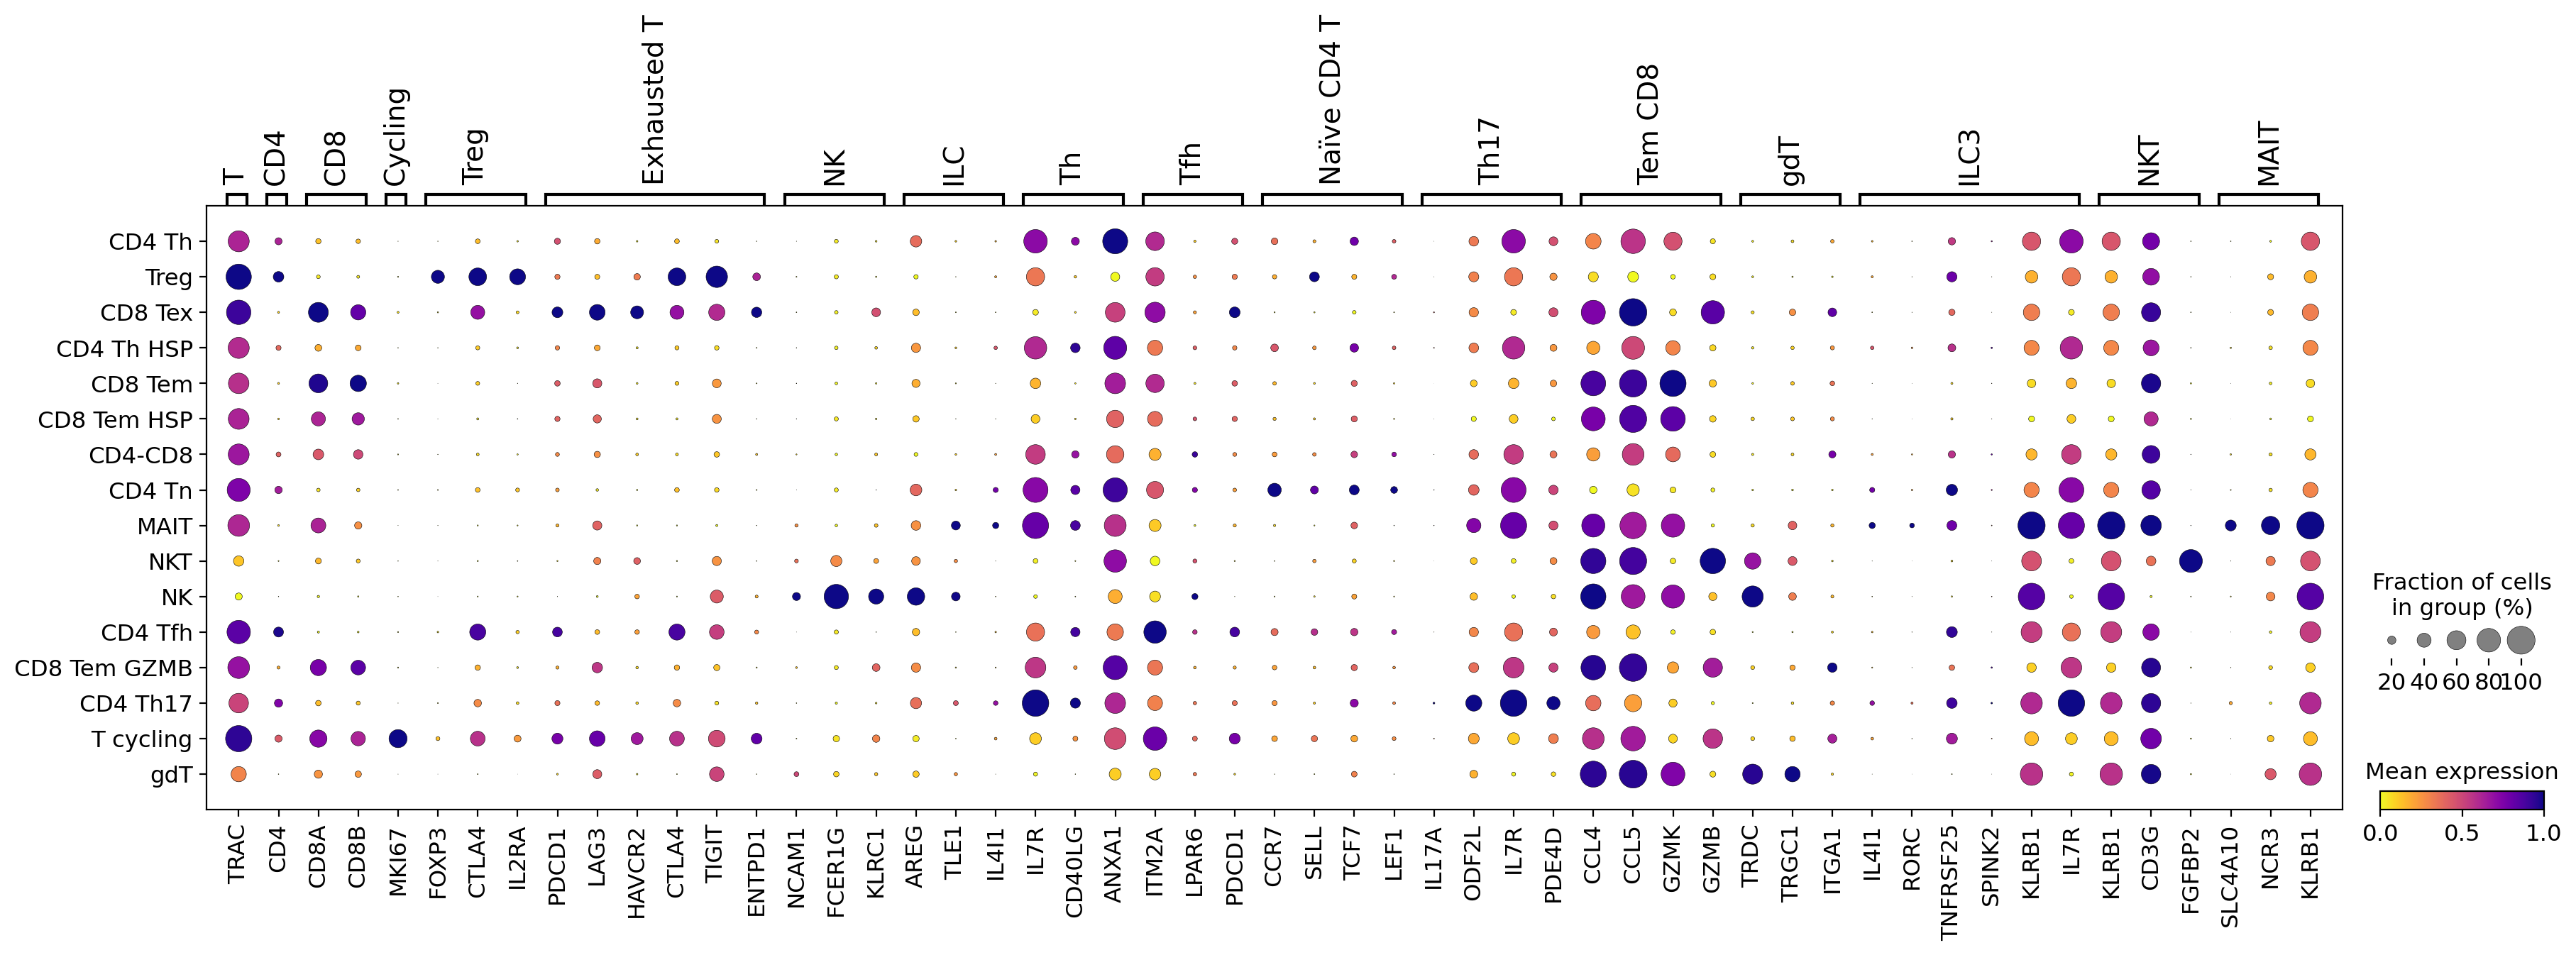

In [22]:
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="TNKILC_dotplot_mean_general_annot.pdf",
    show=True,
)